**This code takes in 3D stacks of nuclei staining, does the prediction on all z-planes using pretrained stardist 2D model. The output could be used in Trackmate to glue together2D masks to generate 3D masks. This is a good way of generating training data for training full stardist 3D models**



**Install and load dependencies**

In [ ]:
!pip install stardist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [ ]:
from stardist.models import StarDist3D


In [ ]:
from stardist.models import StarDist2D


In [ ]:
StarDist3D.from_pretrained()


NameError: ignored

In [ ]:
StarDist2D.from_pretrained()


There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [ ]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')


Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


**Loading the packages done. Work on the image now.**

In [ ]:
from skimage import io

In [ ]:
import numpy as np

In [ ]:
img = io.imread('/content/512_512_3D_stardist_test.tiff')


In [ ]:
img.shape

(68, 512, 512)


**data type of the img**

In [ ]:
# Assuming 'img' is a NumPy array
data_type = img.dtype
print(data_type)

uint8


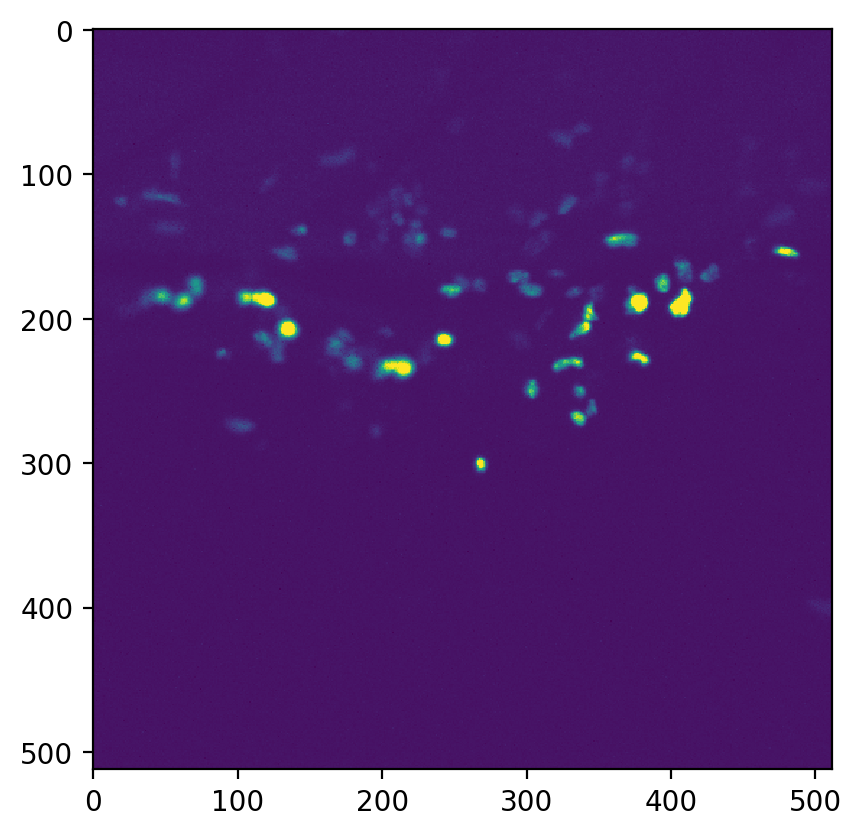

In [ ]:
plt.imshow(img[21, :, :])

**defining the function to create individual slices from z stack**

In [ ]:
def z_slicer(x):
    list_z = []
    z_len = x.shape[0]
    for i in range(z_len):
        img_selected = x[i, :, :]
        list_z.append(img_selected)
    return list_z

In [ ]:
img_z_list = z_slicer(img)

In [ ]:
len(img_z_list)

68

In [ ]:
img_z_list[1]

array([[15, 15, 14, ..., 13, 13, 16],
       [14, 14, 18, ..., 12, 13, 13],
       [14, 16, 15, ..., 11, 16, 14],
       ...,
       [15, 13, 14, ..., 14, 12, 12],
       [12, 11, 12, ..., 13, 13, 15],
       [12, 13, 13, ..., 11, 13, 13]], dtype=uint8)

**Trying stardist to segment one slice**

In [ ]:
img_21 = img[21, :,:]

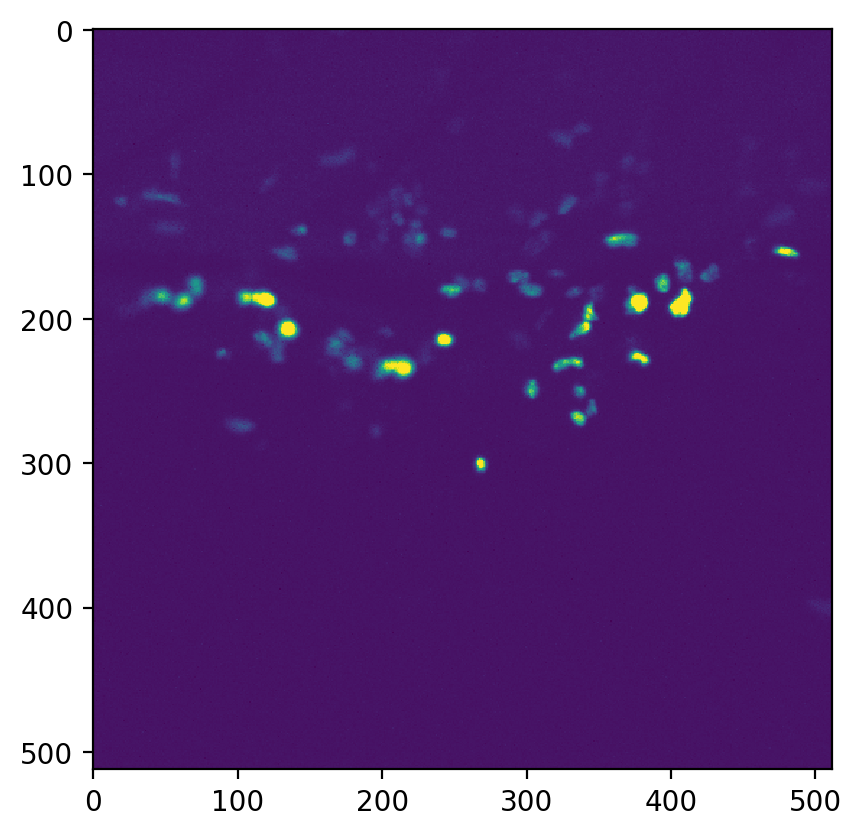

In [ ]:
plt.imshow(img_21)

In [ ]:
labels, _ = model.predict_instances(normalize(img_21))


Text(0.5, 1.0, 'prediction')

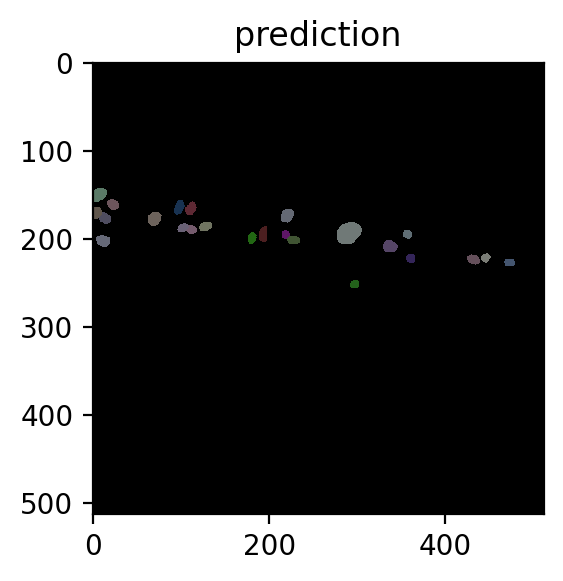

In [ ]:
plt.subplot(1,2,2)
plt.imshow(render_label(labels))
plt.axis("on")
plt.title("prediction")

In [ ]:
from tifffile import imsave, imwrite


**Trying to do it for all slices using a for loop**

In [ ]:
def star_2to3d(img_x):
  img_list =  z_slicer(img_x)
  pred_list = []
  for i in range (len(img_list)):
       labels, _ = model.predict_instances(normalize(img_list[i]))
       pred_list.append(labels)
  return(pred_list)



In [ ]:
predictions_2d = star_2to3d(img)

In [ ]:
len(predictions_2d)

68

In [ ]:
predictions_2d[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

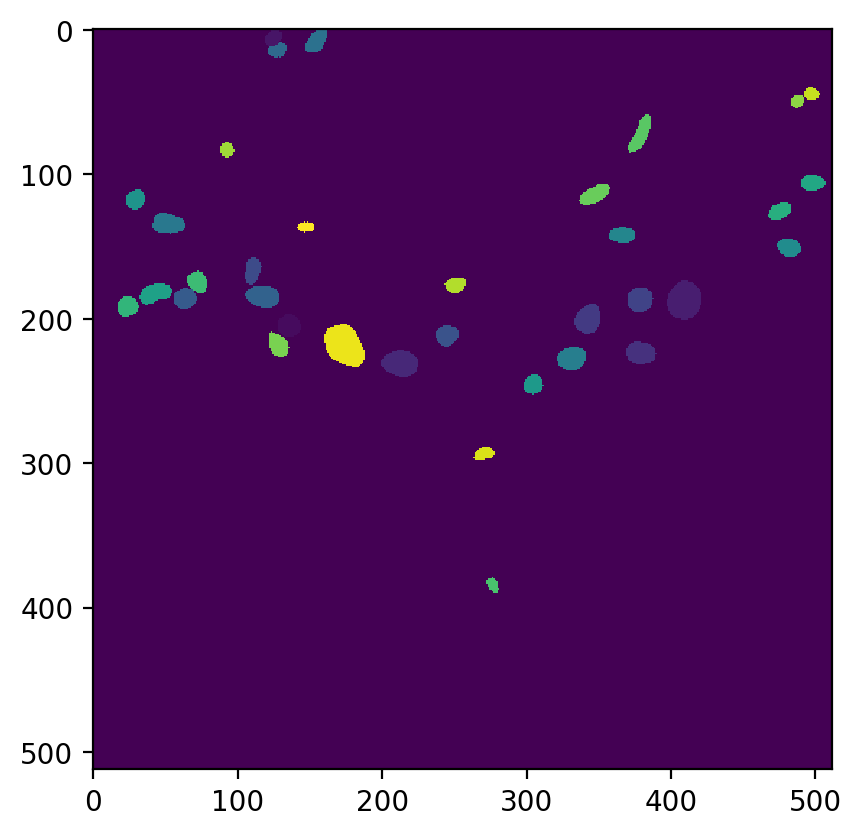

In [ ]:
plt.imshow(predictions_2d[3])

In [ ]:
stacked_3d_image = np.stack(predictions_2d, axis=0)


In [ ]:
stacked_3d_image

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
normalized_array = (stacked_3d_image - stacked_3d_image.min()) / (stacked_3d_image.max() - stacked_3d_image.min())
scaled_array = (normalized_array * 255.0)
arr_uint8 = scaled_array.astype(np.uint8)
pred_downscaled_8bit = arr_uint8

In [ ]:
pred_downscaled_8bit.shape

(68, 512, 512)

In [ ]:
from tifffile import imsave, imwrite


In [ ]:
metadata={'spacing': 2.45 , 'unit': 'pixel', 'axes': 'ZYX'}
imwrite("/content/pred_stacked_2d_image", pred_downscaled_8bit, imagej=True,
        resolution=(1./0.65, 1./0.65
                    ), metadata=metadata) # the values in the denominator is the x y pixel values